# # Day 4 – Data Integration & Schema Design: NYC SAT Results

**Objective:** Understand and clean **real-world SAT results dataset**, prepare it for database storage and integrate into a relational(PostgreSQL) database table satefely using Python.

**Date:** [30-10-2025]

**Dataset:** `sat-results.csv`
- **Rows:** 495
- **Columns:** 11 (will reduce to 7 useful columns)

**Target Database:** PostgreSQL
**Existing Tables:** high_school_directory, school_demographics, school_safety_report




## Step-by-Step Workflow
**Part 1: Explore the CSV to see the structure.**
#### Dataset Issues Identified:
- ❌ Duplicate column: "SAT Critical Reading Avg. Score" appears twice (one has typo)
- ❌ Spaces in column names
- ❌ Percentage signs in `pct_students_tested`
- ❌ Synthetic columns: `internal_school_id`, `contact_extension` 
- ❌ Potential invalid SAT scores (valid range: 200-800)
- ❌ Numbers look strange, like "85%", "N/A", or "--".


In [264]:
# Step 2: Import Libraries 

import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine, text
import warnings
import re

# Configure pandas display settings for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show up to 100 rows
pd.set_option('display.width', None)         # Don't wrap output
warnings.filterwarnings('ignore')            # Suppress warnings

In [265]:
# Step 3: Load and  Initial Explore the SAT Dataset
# oading the CSV file to understand structure and identify data quality issues.
'''
**Expected Issues:**
- Column name inconsistencies
- Duplicate reading score column
- Percentage formatting
- Invalid score ranges
- missing values
- data type issues
'''

df = pd.read_csv('sat-results.csv')

print(f"Shape: {df.shape}")   # Basic shape information
print("\n----------------")
print(f"Columns Names: {df.columns}")
print("\n---------------------")
print(f"General Information Summary: {df.info()}")
print("\n-------------")
display(df.head(10))          # Display first 10 rows to see actual data

Shape: (493, 11)

----------------
Columns Names: Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'SAT Critical Readng Avg. Score',
       'internal_school_id', 'contact_extension', 'pct_students_tested',
       'academic_tier_rating'],
      dtype='object')

---------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              493 non-null    object 
 1   SCHOOL NAME                      493 non-null    object 
 2   Num of SAT Test Takers           493 non-null    object 
 3   SAT Critical Reading Avg. Score  493 non-null    object 
 4   SAT Math Avg. Score              493 non-null    object 
 5   SAT Writing Avg. Score           493 non-null    object 
 6   SAT Cri

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT Critical Readng Avg. Score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,377,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,414,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,390,672714,x123,92%,2.0
5,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,112,332,557,316,332,414951,x345,NaN,3.0
6,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522,574,525,522,697107,NaN,78%,2.0
7,01M650,CASCADES HIGH SCHOOL,18,417,418,411,417,297600,NaN,92%,4.0
8,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624,604,628,624,881396,x234,NaN,NaN
9,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395,400,387,395,751293,NaN,78%,4.0


In [266]:
print("IDENTIFYING DUPLICATE COLUMNS")

cols = [c for c in df.columns if 'reading' in c.lower() or 'readng' in c.lower()]
print(f"Found {len(cols)} reading-related columns:")
for c in cols:
    print("-", c)

if len(cols) == 2:
    a, b = cols
    print(f"Comparing: {a} vs {b}")
    print("Are columns identical?", df[a].equals(df[b]))
    print(a, "samples:", df[a].dropna().head().tolist())
    print(b, "samples:", df[b].dropna().head().tolist())

print(f"\n✅ Keep: '{a}'")
print(f"❌ Drop: '{b}'")

IDENTIFYING DUPLICATE COLUMNS
Found 2 reading-related columns:
- SAT Critical Reading Avg. Score
- SAT Critical Readng Avg. Score
Comparing: SAT Critical Reading Avg. Score vs SAT Critical Readng Avg. Score
Are columns identical? True
SAT Critical Reading Avg. Score samples: ['355', '383', '377', '414', '390']
SAT Critical Readng Avg. Score samples: ['355', '383', '377', '414', '390']

✅ Keep: 'SAT Critical Reading Avg. Score'
❌ Drop: 'SAT Critical Readng Avg. Score'


In [267]:
# step 4 Check for Synthetic/Irrelevant Columns 

print("ANALYZING POTENTIALLY SYNTHETIC/IRRELEVANT COLUMNS")

# Check internal_school_id column
if 'internal_school_id' in df.columns:
    print("\ninternal_school_id")
    print("Unique:", df['internal_school_id'].nunique())
    print("Samples:", df['internal_school_id'].head(5).tolist())
    print("Drop this column")

# Check contact_extension column
if 'contact_extension' in df.columns:
    print("\ncontact_extension")
    print("Unique:", df['contact_extension'].nunique())
    print("Not null:", df['contact_extension'].notna().sum())
    print("Samples:", df['contact_extension'].head(5).tolist())
    print("Drop this column")

# Check academic_tier_rating column
if 'academic_tier_rating' in df.columns:
    print("\nacademic_tier_rating")
    print("Unique:", df['academic_tier_rating'].nunique())
    print("Value counts:\n", df['academic_tier_rating'].value_counts())
    print("Samples:", df['academic_tier_rating'].head(5).tolist())
    print("Maybe keep or drop after review")

print("\nCOLUMNS TO KEEP:")
print("1. DBN - Primary key (links to other tables)")
print("2. SCHOOL NAME - School identifier")
print("3. Num of SAT Test Takers - Number of students tested")
print("4. SAT Critical Reading Avg. Score - Reading score")
print("5. SAT Math Avg. Score - Math score")
print("6. SAT Writing Avg. Score - Writing score")
print("7. pct_students_tested - Percentage tested (after cleaning)")

ANALYZING POTENTIALLY SYNTHETIC/IRRELEVANT COLUMNS

internal_school_id
Unique: 478
Samples: [218160, 268547, 236446, 427826, 672714]
Drop this column

contact_extension
Unique: 3
Not null: 388
Samples: ['x345', 'x234', 'x123', 'x123', 'x123']
Drop this column

academic_tier_rating
Unique: 4
Value counts:
 academic_tier_rating
4.0    112
2.0    101
3.0     96
1.0     93
Name: count, dtype: int64
Samples: [2.0, 3.0, 3.0, 4.0, 2.0]
Maybe keep or drop after review

COLUMNS TO KEEP:
1. DBN - Primary key (links to other tables)
2. SCHOOL NAME - School identifier
3. Num of SAT Test Takers - Number of students tested
4. SAT Critical Reading Avg. Score - Reading score
5. SAT Math Avg. Score - Math score
6. SAT Writing Avg. Score - Writing score
7. pct_students_tested - Percentage tested (after cleaning)


In [268]:
# Data Quality Check

print("DATA QUALITY ANALYSIS")

# Check for Missing values
print("\nMISSING VALUES")
missing = df.isnull().sum()
print(missing[missing > 0])

if missing.sum() == 0:
    print("No missing values!")

# Check for duplicate rows in df
print("\nDUPLICATE ANALYSIS")
print("Exact duplicate rows:", df.duplicated().sum())

# Check for Duplicate DBN
if 'DBN' in df.columns:
    print("Duplicate DBNs:", df['DBN'].duplicated().sum())
    if df['DBN'].duplicated().sum() > 0:
        dups = df[df['DBN'].duplicated(keep=False)]
        print(dups[['DBN', 'SCHOOL NAME']])

# Check for Null/empty DBNs
if 'DBN' in df.columns:
    null_dbn = df['DBN'].isnull().sum()
    empty_dbn = (df['DBN'].astype(str).str.strip() == '').sum()
    print("Null DBNs:", null_dbn)
    print("Empty DBNs:", empty_dbn)
    if null_dbn > 0 or empty_dbn > 0:
        print("DBN is required!")
    else:
        print("All DBNs are valid!")

DATA QUALITY ANALYSIS

MISSING VALUES
contact_extension       105
pct_students_tested     117
academic_tier_rating     91
dtype: int64

DUPLICATE ANALYSIS
Exact duplicate rows: 15
Duplicate DBNs: 15
        DBN                                        SCHOOL NAME
35   02M419                               LANDMARK HIGH SCHOOL
52   02M520   MURRY BERGTRAUM HIGH SCHOOL FOR BUSINESS CAREERS
99   05M304                              MOTT HALL HIGH SCHOOL
119  07X221    SOUTH BRONX PREPARATORY: A COLLEGE BOARD SCHOOL
177  09X525               BRONX LEADERSHIP ACADEMY HIGH SCHOOL
258  13K605  GEORGE WESTINGHOUSE CAREER AND TECHNICAL EDUCA...
276  14K685            EL PUENTE ACADEMY FOR PEACE AND JUSTICE
306  17K543  SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
331  19K420                       FRANKLIN K. LANE HIGH SCHOOL
414  27Q480                             JOHN ADAMS HIGH SCHOOL
478  14K685            EL PUENTE ACADEMY FOR PEACE AND JUSTICE
479  13K605  GEORGE WESTINGHOUSE CAREER AND T

In [269]:
# Analyze SAT Score Columns

print("SAT SCORE ANALYSIS (Valid Range: 200-800)")

# Identify the three main SAT score columns (excluding the duplicate)
cols = [
    'SAT Critical Reading Avg. Score',
    'SAT Math Avg. Score',
    'SAT Writing Avg. Score'
]

for col in cols:
    if col in df.columns:
        # Convert to numeric first (handles any string values)
        scores = pd.to_numeric(df[col], errors='coerce')

        # Basic statistics
        print(f"\n{col}:")
        print("Min:", scores.min(), "Max:", scores.max(), "Mean:", scores.mean(), "Median:", scores.median())
        
        
        # Check valid range (200-800)
        print("Valid (200-800):", ((scores >= 200) & (scores <= 800)).sum())
        print("Too low (<200):", (scores < 200).sum())
        print("Too high (>800):", (scores > 800).sum())
        
        

SAT SCORE ANALYSIS (Valid Range: 200-800)

SAT Critical Reading Avg. Score:
Min: 279.0 Max: 679.0 Mean: 400.71264367816093 Median: 391.0
Valid (200-800): 435
Too low (<200): 0
Too high (>800): 0

SAT Math Avg. Score:
Min: -10.0 Max: 1100.0 Mean: 417.64367816091954 Median: 396.0
Valid (200-800): 430
Too low (<200): 1
Too high (>800): 4

SAT Writing Avg. Score:
Min: 286.0 Max: 682.0 Mean: 393.71264367816093 Median: 382.0
Valid (200-800): 435
Too low (<200): 0
Too high (>800): 0


In [270]:
# Analyze Other Columns

print("ANALYZING OTHER COLUMNS")

# Analyze Num of SAT Test Takers
print("\n--- Num of SAT Test Takers ---")
if 'Num of SAT Test Takers' in df.columns:
    vals = pd.to_numeric(df['Num of SAT Test Takers'], errors='coerce')
    print("Num of SAT Test Takers stats:", vals.min(), vals.max(), vals.mean())
    # Check for unrealistic values
    print("Count 0:", (vals == 0).sum())
    print("Count negative:", (vals < 0).sum())


# Analyze pct_students_tested
print("\n--- pct_students_tested ---")
if 'pct_students_tested' in df.columns:
    vals = df['pct_students_tested'].astype(str).str.replace('%', '').str.strip()
    nums = pd.to_numeric(vals, errors='coerce')
    print("pct_students_tested min/max/mean:", nums.min(), nums.max(), nums.mean())
    # Check for percentage signs
    print("With % sign:", df['pct_students_tested'].astype(str).str.contains('%').sum())
     # Check for values outside 0-100
    print("Negative:", (nums < 0).sum(), "Above 100:", (nums > 100).sum())

# Analyze SCHOOL NAME

print("\n--- SCHOOL NAME ---")
if 'SCHOOL NAME' in df.columns:
    print("Unique schools:", df['SCHOOL NAME'].nunique())
    print("Non-null count:", df['SCHOOL NAME'].notna().sum())
    print("Sample names:", df['SCHOOL NAME'].head().tolist())

ANALYZING OTHER COLUMNS

--- Num of SAT Test Takers ---
Num of SAT Test Takers stats: 6.0 1277.0 111.40229885057471
Count 0: 0
Count negative: 0

--- pct_students_tested ---
pct_students_tested min/max/mean: 78.0 92.0 84.68351063829788
With % sign: 376
Negative: 0 Above 100: 0

--- SCHOOL NAME ---
Unique schools: 478
Non-null count: 493
Sample names: ['HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES', 'UNIVERSITY NEIGHBORHOOD HIGH SCHOOL', 'EAST SIDE COMMUNITY SCHOOL', 'FORSYTH SATELLITE ACADEMY', 'MARTA VALLE HIGH SCHOOL']


## Part 2: Data cleaning

**Cleaning Steps:**

### 1. Drop Unnecessary Columns
- ❌ `SAT Critical Readng Avg. Score` (duplicate with typo)
- ❌ `internal_school_id` (synthetic/not useful)
- ❌ `contact_extension` (not relevant)
- ⚠️  `academic_tier_rating` (evaluate if synthetic)

### 2. Clean Column Names
- Convert to lowercase
- Replace spaces with underscores
- Remove special characters

### 3. Remove Duplicates
- Remove exact duplicate rows
- Handle duplicate DBNs (keep first occurrence)

### 4. Clean SAT Scores
- Convert to numeric
- Set values outside 200-800 to NULL

### 5. Clean Percentage Column
- Remove '%' signs
- Convert to numeric (0-100 range)
- Validate range

### 6. Validate DBN
- Ensure no nulls
- Trim whitespace
- Ensure consistent format

---

In [271]:
print("STEP 1: DROPPING UNNECESSARY COLUMNS")

df_clean = df.copy()        # Create a copy for cleaning
cols_to_drop = []           # List columns to drop

if 'SAT Critical Readng Avg. Score' in df_clean.columns: # Drop the duplicate reading column with typo
    cols_to_drop.append('SAT Critical Readng Avg. Score')


# Drop synthetic/irrelevant columns
if 'internal_school_id' in df_clean.columns:
    cols_to_drop.append('internal_school_id')
if 'contact_extension' in df_clean.columns:
    cols_to_drop.append('contact_extension')

if 'academic_tier_rating' in df_clean.columns:
    unique_count = df_clean['academic_tier_rating'].nunique()
    missing_rate = df_clean['academic_tier_rating'].isnull().mean()
    
    print(f"\n--- Analyzing academic_tier_rating ---")
    print(f"  Unique values: {unique_count}")
    print(f"  Missing rate: {missing_rate:.1%}")
    print(f"  Distribution:\n{df_clean['academic_tier_rating'].value_counts().sort_index()}")
    print("  ✅ Decision: KEEP")
    print("     Reasons:")
    print("     • Has 4 distinct tiers (1-4 rating system)")
    print("     • 81.2% data coverage (only 18.8% missing)")
    print("     • Enables tier-based analysis (SAT performance by tier)")
    print("     • Can be excluded from queries if not needed later")

# Drop the columns
df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')
print("Dropped:", cols_to_drop)
print("Columns left:", df_clean.columns.tolist())

print("\n✅ Unnecessary columns removed")

STEP 1: DROPPING UNNECESSARY COLUMNS

--- Analyzing academic_tier_rating ---
  Unique values: 4
  Missing rate: 18.5%
  Distribution:
academic_tier_rating
1.0     93
2.0    101
3.0     96
4.0    112
Name: count, dtype: int64
  ✅ Decision: KEEP
     Reasons:
     • Has 4 distinct tiers (1-4 rating system)
     • 81.2% data coverage (only 18.8% missing)
     • Enables tier-based analysis (SAT performance by tier)
     • Can be excluded from queries if not needed later
Dropped: ['SAT Critical Readng Avg. Score', 'internal_school_id', 'contact_extension']
Columns left: ['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', 'pct_students_tested', 'academic_tier_rating']

✅ Unnecessary columns removed


In [272]:
print("STEP 2: CLEANING COLUMN NAMES")

print("Original columns:", df_clean.columns.tolist())

df_clean.columns = (
    df_clean.columns
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(r'[^a-z0-9_]', '', regex=True)
        .str.replace(r'_+', '_', regex=True)
        .str.strip('_')
)

print("Cleaned columns:", df_clean.columns.tolist())

print("\n✅ Column names cleaned")

STEP 2: CLEANING COLUMN NAMES
Original columns: ['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers', 'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score', 'SAT Writing Avg. Score', 'pct_students_tested', 'academic_tier_rating']
Cleaned columns: ['dbn', 'school_name', 'num_of_sat_test_takers', 'sat_critical_reading_avg_score', 'sat_math_avg_score', 'sat_writing_avg_score', 'pct_students_tested', 'academic_tier_rating']

✅ Column names cleaned


In [273]:
print("STEP 3: REMOVING DUPLICATES")

print("Starting rows:", len(df_clean))
print("Exact duplicate rows:", df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()

if 'dbn' in df_clean.columns:
    print("Duplicate DBNs:", df_clean['dbn'].duplicated().sum())
    df_clean = df_clean.drop_duplicates(subset='dbn', keep='first')

print("Rows after cleaning:", len(df_clean))

print("\n✅ Duplicates removed")

STEP 3: REMOVING DUPLICATES
Starting rows: 493
Exact duplicate rows: 15
Duplicate DBNs: 0
Rows after cleaning: 478

✅ Duplicates removed


In [274]:
print("STEP 4: CLEANING SAT SCORE COLUMNS")

for col in ['sat_critical_reading_avg_score', 'sat_math_avg_score', 'sat_writing_avg_score']:
    if col in df_clean.columns:
        vals = pd.to_numeric(df_clean[col], errors='coerce')
        vals = vals.where((vals >= 200) & (vals <= 800))
        df_clean[col] = vals.astype('Int64')
        print(f"{col}: cleaned")

print("\n✅ SAT scores cleaned and validated")

STEP 4: CLEANING SAT SCORE COLUMNS
sat_critical_reading_avg_score: cleaned
sat_math_avg_score: cleaned
sat_writing_avg_score: cleaned

✅ SAT scores cleaned and validated


In [275]:
print("STEP 4B: CLEANING ACADEMIC_TIER_RATING")

if 'academic_tier_rating' in df_clean.columns:
    # Convert to numeric
    vals = pd.to_numeric(df_clean['academic_tier_rating'], errors='coerce')
    # Keep only 1-4, set others to NaN
    vals = vals.where((vals >= 1) & (vals <= 4))
    # Convert to nullable int
    df_clean['academic_tier_rating'] = vals.astype('Int64')
    print("academic_tier_rating: cleaned")

print("\n✅ academic_tier_rating cleaned")

STEP 4B: CLEANING ACADEMIC_TIER_RATING
academic_tier_rating: cleaned

✅ academic_tier_rating cleaned


In [276]:
print("STEP 5: CLEANING NUMBER OF TEST TAKERS")

col = 'num_of_sat_test_takers'
if col in df_clean.columns:
    vals = pd.to_numeric(df_clean[col], errors='coerce')
    vals = vals.where(vals >= 0)
    df_clean[col] = vals.astype('Int64')
    print(f"{col}: cleaned")

print("\n✅ Test takers cleaned")

STEP 5: CLEANING NUMBER OF TEST TAKERS
num_of_sat_test_takers: cleaned

✅ Test takers cleaned


In [277]:
print("STEP 6: CLEANING PERCENTAGE COLUMN (pct_students_tested)")

col = 'pct_students_tested'
if col in df_clean.columns:
    # Remove % signs, commas, and spaces
    vals = df_clean[col].astype(str).str.replace('%', '').str.replace(',', '').str.strip()
    # Convert to numbers
    vals = pd.to_numeric(vals, errors='coerce')
    # Keep only 0-100, set others to NaN
    vals = vals.where((vals >= 0) & (vals <= 100))
    # Round to 2 decimals
    df_clean[col] = vals.round(2)
    print(f"{col}: cleaned")
    
print("\n✅ Percentage column cleaned and validated")

STEP 6: CLEANING PERCENTAGE COLUMN (pct_students_tested)
pct_students_tested: cleaned

✅ Percentage column cleaned and validated


In [279]:
# 🧮 STEP 7: CREATE TOTAL SAT SCORE FEATURE
# ============================================================

print("STEP 7: FEATURE ENGINEERING — CREATING TOTAL SAT SCORE")


# Define the score columns
score_cols = [
    'sat_critical_reading_avg_score',
    'sat_math_avg_score',
    'sat_writing_avg_score'
]

# Check all required columns exist
missing_cols = [col for col in score_cols if col not in df_clean.columns]
if missing_cols:
    print(f"❌ Missing columns: {missing_cols}. Cannot create total SAT score.")
else:
    # Convert to numeric (in case any are strings)
    df_clean[score_cols] = df_clean[score_cols].apply(pd.to_numeric, errors='coerce')

    # Calculate total SAT score
    df_clean['sat_total_score'] = (
        df_clean[score_cols[0]].fillna(0) +
        df_clean[score_cols[1]].fillna(0) +
        df_clean[score_cols[2]].fillna(0)
    )

    # Replace 0s with NaN where all 3 parts were missing
    df_clean.loc[df_clean[score_cols].isna().all(axis=1), 'sat_total_score'] = pd.NA

    # Convert to nullable integer type (allows missing values)
    df_clean['sat_total_score'] = df_clean['sat_total_score'].astype('Int64')

    print("✅ 'sat_total_score' column successfully created!")
    print("Preview of calculated scores:")
    print(df_clean[['school_name', 'sat_total_score']].head())


print("Feature engineering complete.")



STEP 7: FEATURE ENGINEERING — CREATING TOTAL SAT SCORE
✅ 'sat_total_score' column successfully created!
Preview of calculated scores:
                                     school_name  sat_total_score
0  HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES             1122
1            UNIVERSITY NEIGHBORHOOD HIGH SCHOOL             1172
2                     EAST SIDE COMMUNITY SCHOOL             1149
3                      FORSYTH SATELLITE ACADEMY             1174
4                        MARTA VALLE HIGH SCHOOL             1207
Feature engineering complete.


In [280]:
df_clean[['sat_critical_reading_avg_score','sat_math_avg_score','sat_writing_avg_score','sat_total_score']].head()


,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,sat_total_score
0,355,404,363,1122
1,383,423,366,1172
2,377,402,370,1149
3,414,401,359,1174
4,390,433,384,1207


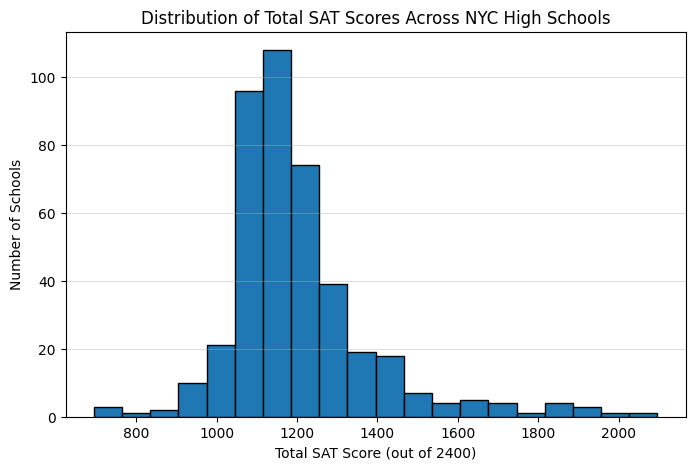

In [281]:
# Visualizing Results in Python

# Histogram of Total SAT Scores

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_clean["sat_total_score"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of Total SAT Scores Across NYC High Schools")
plt.xlabel("Total SAT Score (out of 2400)")
plt.ylabel("Number of Schools")
plt.grid(axis="y", alpha=0.4)
plt.show()


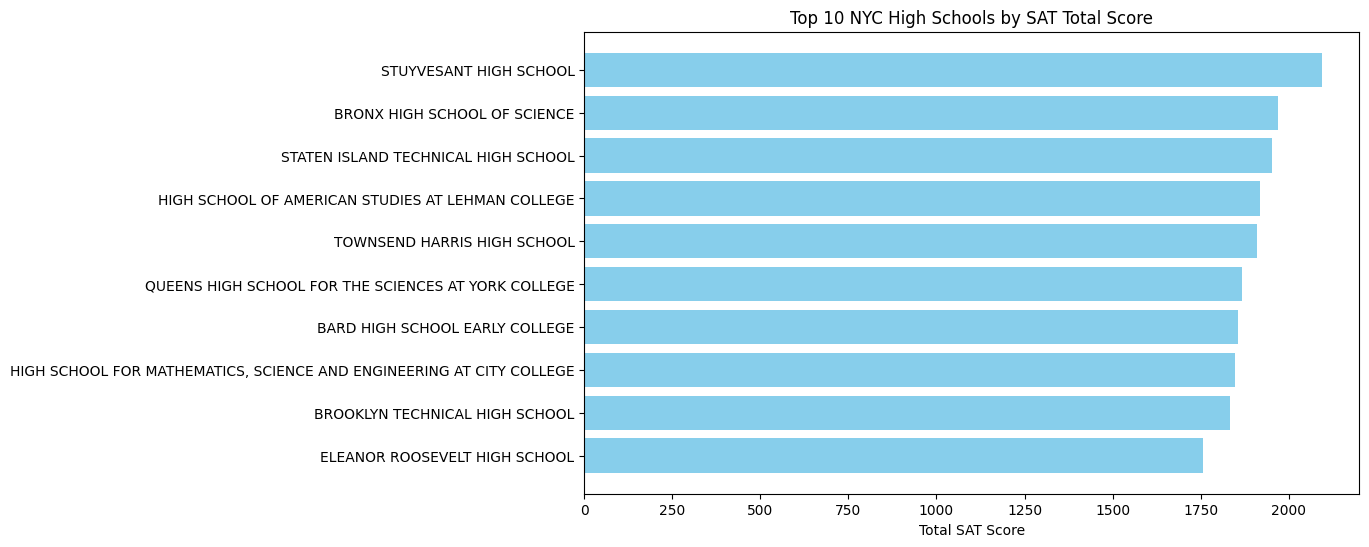

In [282]:
# Top 10 Schools by Total SAT Score

top10 = df_clean.nlargest(10, "sat_total_score")[["school_name", "sat_total_score"]]

plt.figure(figsize=(10,6))
plt.barh(top10["school_name"], top10["sat_total_score"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 10 NYC High Schools by SAT Total Score")
plt.xlabel("Total SAT Score")
plt.show()


### 📊 Key Insights from NYC High School SAT Data

#### Top Performers
- The bar chart highlights the dominance of specialized high schools like **Stuyvesant** and **Bronx Science**, with total SAT scores exceeding **1900**.  

- These schools clearly outperform the broader system, demonstrating the effectiveness of selective academic environments.

#### System-Wide Distribution
- The histogram shows that the majority of NYC high schools cluster around **1100–1300 total SAT points**, well below the top performers.  

- Only a small fraction of schools achieve scores above **1600**, indicating a significant gap between elite and average schools.

#### Performance Gap
- There is a **700+ point gap** between the average school and top specialized schools, reinforcing the need for targeted interventions to boost college readiness across the system.

#### Takeaway
A small group of elite schools achieves exceptional outcomes, while most schools perform below the college readiness benchmark, emphasizing the need for **system-wide academic support and resource allocation**.


In [283]:
print("Cleaned data:", df_clean.shape)
display(df_clean['sat_total_score'].notna().sum())


Cleaned data: (478, 9)


np.int64(421)

In [284]:
# ============================================================
# STEP 7b: VALIDATE SAT TOTAL SCORES BEFORE DATABASE UPLOAD
# ============================================================

print("STEP 7b: VALIDATING SAT TOTAL SCORES")


# Check range of SAT totals
valid_range = (df_clean['sat_total_score'].between(600, 2400)) | (df_clean['sat_total_score'].isna())

invalid_rows = df_clean[~valid_range]

if invalid_rows.empty:
    print("✅ All SAT total scores are within the valid range (600–2400)!")
else:
    print(f"⚠️ Found {len(invalid_rows)} rows with invalid SAT totals:")
    print(invalid_rows[['dbn', 'school_name', 'sat_total_score']].head())
    # Optional: drop invalid rows
    df_clean = df_clean[valid_range]
    print("🚮 Invalid rows removed from dataset.")

print(f"\nFinal cleaned data ready for upload: {df_clean.shape}")



STEP 7b: VALIDATING SAT TOTAL SCORES
✅ All SAT total scores are within the valid range (600–2400)!

Final cleaned data ready for upload: (478, 9)


---

## PART 3: Prepare Data for Database

**Final Dataset Summary:**

We've cleaned and prepared the following columns for database storage:

### Columns to Store in Database:
1. **dbn** (VARCHAR, PRIMARY KEY) - School identifier
2. **school_name** (VARCHAR) - School name
3. **num_of_sat_test_takers** (INTEGER) - Number of students tested
4. **sat_critical_reading_avg_score** (INTEGER) - Reading score (200-800)
5. **sat_math_avg_score** (INTEGER) - Math score (200-800)
6. **sat_writing_avg_score** (INTEGER) - Writing score (200-800)
7. **sat_total_score** (INTEGER) - Total score (600-2400)
8. **pct_students_tested** (DECIMAL) - Percentage of students tested (0-100)
9. **academic_tier_rating** (INTEGER, nullable) - Academic tier (1-4)

**Data Quality Checks:**
- ✅ No duplicate DBNs
- ✅ No NULL DBNs
- ✅ SAT scores validated (200-800 per section)
- ✅ Percentages validated (0-100)
- ✅ Total score calculated

---

In [285]:
import psycopg2
from sqlalchemy import create_engine, text

print("🔗 PART 3: DATABASE CONNECTION SETUP")


# --- 🔧 Step 1: Define my PostgreSQL credentials ---
DB_HOST = "localhost"             # remote host
DB_PORT = "5432"                  # default PostgreSQL port
DB_NAME = "sat_school_data"       # your database name
DB_USER = "postgres"              # username fromal(onyx_owner)
DB_PASSWORD = "SatData#2025"      # (formal PW = opg_Ugba9fJg2azZD)

# --- Step 2: Connect using psycopg2 ---
try:
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    conn.autocommit = False
    cursor = conn.cursor()
    print("✅ Connected to PostgreSQL successfully!")

    # Test query
    cursor.execute("SELECT version();")
    version = cursor.fetchone()
    print(f"✅ Connected successfully! PostgreSQL version: {version[0]}")
    
except psycopg2.Error as e:
    print("❌ Connection failed!")
    print(f"Error: {e}")
    print("🧩 Troubleshooting checklist:")
    print("  1. Ensure PostgreSQL service is running (check pgAdmin or Services)")
    print("  2. Confirm your credentials match pgAdmin login")
    print("  3. Verify the database name exists")
    print("  4. Check firewall or localhost port issues")
    raise




🔗 PART 3: DATABASE CONNECTION SETUP
✅ Connected to PostgreSQL successfully!
✅ Connected successfully! PostgreSQL version: PostgreSQL 16.10, compiled by Visual C++ build 1944, 64-bit


In [286]:
# Step 3: Create SQLAlchemy Engine (for Pandas)
# ============================================
try:
    engine = create_engine(
        f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    )
    with engine.connect() as test_conn:
        test_conn.execute(text("SELECT 1"))
    print("✅ SQLAlchemy engine created successfully!")
except Exception as e:
    print(f"❌ SQLAlchemy engine creation failed: {e}")
    raise

# ============================================
# Step 4: Close connections safely
# ============================================
print("\n🔒 Ready to start database tasks (SQLAlchemy handles connections!)")

✅ SQLAlchemy engine created successfully!

🔒 Ready to start database tasks (SQLAlchemy handles connections!)


In [287]:
# SQL statement to create my table
create_table_sql = """
CREATE TABLE IF NOT EXISTS onyi_ugba_sat_scores (
    dbn VARCHAR(20) PRIMARY KEY,
    school_name VARCHAR(255),
    num_of_sat_test_takers INTEGER,
    sat_critical_reading_avg_score INTEGER,
    sat_math_avg_score INTEGER,
    sat_writing_avg_score INTEGER,
    sat_total_score INTEGER,
    pct_students_tested DECIMAL(5,2),
    academic_tier_rating INTEGER,
    created_at TIMESTAMP DEFAULT NOW()
);
"""

# Execute SQL command
with engine.connect() as conn: # Renamed 'conn' to 'connection' for clarity
    conn.execute(text(create_table_sql))
    print("✅ Table 'onyi_ugba_sat_scores' created successfully in PostgreSQL!")

✅ Table 'onyi_ugba_sat_scores' created successfully in PostgreSQL!


In [289]:
# 💾 Export Cleaned Data to CSV (Snapshot)

df_clean.to_csv('clean_sat_results.csv', 
                index=False  # Exclude the Pandas index from the CSV
                )
print("✅ Data(df_clean) successfully saved as 'clean_sat_results.csv'!")

✅ Data(df_clean) successfully saved as 'clean_sat_results.csv'!


In [290]:
# 💾 Step 10: Upload Cleaned Data to Database
# ============================================================

# Confirm columns match our database schema
print("🧩 Columns to upload:", df_clean.columns.tolist())

# Upload to PostgreSQL
df_clean.to_sql(
    "onyi_ugba_sat_scores",   # table name
    engine,
    if_exists="replace",      # or "append" if i want to keep old data
    index=False
)

print("✅ Data successfully uploaded to PostgreSQL!")


🧩 Columns to upload: ['dbn', 'school_name', 'num_of_sat_test_takers', 'sat_critical_reading_avg_score', 'sat_math_avg_score', 'sat_writing_avg_score', 'pct_students_tested', 'academic_tier_rating', 'sat_total_score']
✅ Data successfully uploaded to PostgreSQL!


In [291]:
# 🔍 Step 11: Verify Record Count in PostgreSQL
# ============================================================

# from sqlalchemy import text - 'text' is now imported at the top

verify_query = "SELECT COUNT(*) FROM onyi_ugba_sat_scores;"

with engine.connect() as conn:
    result = conn.execute(text(verify_query))
    record_count = result.scalar()

print(f"✅ Total records successfully stored: {record_count}")

✅ Total records successfully stored: 478


# 📊 Project Data Processing Summary: NYC SAT Data Cleaning and Integration

## 1. Data Cleaning and Feature Engineering Logic

The primary goal was to validate the data and prepare it for database storage by enforcing standardization and data integrity rules.

| Cleaning Step | Action Taken | Rationale |
| :--- | :--- | :--- |
| **Column Selection** | Dropped irrelevant/duplicate columns (e.g., `SAT Critical Readng Avg. Score`, `internal_school_id`, `contact_extension`). | Streamlined the dataset to only necessary fields. |
| **Name Standardization** | Converted column names to **snake\_case**; removed special characters. | Ensures consistency and easy querying in SQL. |
| **Data Validation** | Removed **exact duplicates** and enforced a unique entry for each **DBN** (keeping the first occurrence). | Guarantees data integrity and correct primary key usage. |
| **Score Validation** | SAT component scores were checked, and values **outside the official 200-800 range were set to NULL**. | Enforces data integrity against the official scoring scale. |
| **Percentage Cleaning** | Removed '%' signs, converted to numeric, and validated the 0-100 range. | Prepares `pct_students_tested` for the `DECIMAL` field type. |
| **Feature Creation** | **`sat_total_score`** was calculated. If all three component scores were missing (NULL), the total was **explicitly set to NULL (pd.NA)**. | Creates the core analysis metric while preventing misleading zero totals. |

---

## 2. Database Integration Strategy

The cleaned data was saved to a CSV for backup, then uploaded to PostgreSQL using SQLAlchemy and Pandas.

| Destination Table | `onyi_ugba_sat_scores` |
| :--- | :--- |
| **Primary Key** | `dbn` (**VARCHAR**) |
| **Total Records** | 478 |
| **Integration Method** | `df_clean.to_sql(..., if_exists="replace")` |
| **Data Snapshot** | A **`df_clean.csv`** file was created *before* the database upload for portable backup and verification. |
| **Type Alignment** | Pandas' **nullable integer (`Int64`)** was used for scores, mapping correctly to PostgreSQL's **INTEGER** column, which allows NULLs. |

---

## 3. 🚩 Challenges Encountered

* **Tooling/Environment:** Significant difficulty integrating **VS Code, Python, and PostgreSQL** due to unfamiliarity with the required connection string formats, SQLAlchemy syntax, and library setup.
* **Data Consistency:** Ensuring that Pandas' specific handling of **missing integer data (`pd.NA`)** correctly translated to a true **NULL** value in the PostgreSQL `INTEGER` column, which was vital for the integrity of the calculated `sat_total_score`.

In [263]:
# 📊 Step 12: Validate and Explore Data
# ============================================================

# 1️⃣ Top 10 schools by total SAT score
query_top10 = """
SELECT school_name, sat_total_score
FROM onyi_ugba_sat_scores
WHERE sat_total_score IS NOT NULL
ORDER BY sat_total_score DESC
LIMIT 10;
"""

# 2️⃣ Average SAT scores across all schools
query_avg_scores = """
SELECT
    ROUND(AVG(sat_math_avg_score), 2) AS avg_math,
    ROUND(AVG(sat_critical_reading_avg_score), 2) AS avg_reading,
    ROUND(AVG(sat_writing_avg_score), 2) AS avg_writing
FROM onyi_ugba_sat_scores;
"""

with engine.connect() as conn:
    top10 = pd.read_sql(text(query_top10), conn)  # Added text() here for maximum compatibility and protection against SQL injection.
    avg_scores = pd.read_sql(text(query_avg_scores), conn) # Added text() here for cfor maximum compatibility and protection against SQL injection.

print("🏆 Top 5 Schools by Total SAT Score:")
display(top10)

print("\n📊 Average SAT Scores Across All Schools:")
display(avg_scores)


🏆 Top 5 Schools by Total SAT Score:


,school_name,sat_total_score
0,STUYVESANT HIGH SCHOOL,2096
1,BRONX HIGH SCHOOL OF SCIENCE,1969
2,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953
3,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920
4,TOWNSEND HARRIS HIGH SCHOOL,1910
5,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868
6,BARD HIGH SCHOOL EARLY COLLEGE,1856
7,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847
8,BROOKLYN TECHNICAL HIGH SCHOOL,1833
9,ELEANOR ROOSEVELT HIGH SCHOOL,1758



📊 Average SAT Scores Across All Schools:


,avg_math,avg_reading,avg_writing
0,413.73,400.85,393.99


# 📈 Business Insight: Interpreting SAT Score Data

This data provides a snapshot of high school performance, revealing both top-tier excellence and system-wide challenges within the reported SAT scores.

---

## 1. 🏆 The Elite Performance Gap

High SAT scores are almost exclusively driven by selective admissions. The specialized and highly selective high schools (Top 10) form a tight, elite plateau (1800-2100 total score range), confirming the effectiveness of the specialized model in achieving top scores.


| School Group | Total SAT Score Range | Impact on System |
|----------|---------------|---------|
| **Top 10 (Selective)**    | $1700 - 2100+$        | Validates concentrated academic resources. |
| **System Average** | $\approx 1208$        | Highlights the massive $700+$ point disparity. |

**Insight:** The current policy validates excellence for a few but exacerbates the gap. The system must study the non-admissions-related factors (e.g., funding, advanced curricula, teacher experience) of these elite schools to inform best practices for non-selective schools.

---

## 2. 📉 System-Wide Performance Challenge


| Category | Average Score | Context |
|----------|---------------|---------|
| Math     | 413.73        | Below average |
| Reading  | 400.85        | At the minimum (400) |
| Writing  | 393.99        | Below the minimum (400) |
| **Total** | ~1208        | Far below college readiness baseline |


**Insight:** The majority of schools are performing significantly below the college-ready benchmark. This highlights a critical need for **system-wide academic intervention, resource reallocation, and targeted programs** to boost core skills (especially in writing and reading) in non-specialized schools. Policy resources should be heavily weighted towards the schools in the $1000-1300$ cluster to shift the entire primary distribution mass to the right, aiming to raise the system average closer to $1500$.

---

## 3. 🎯 Strategic Recommendations

1. **Resource Reallocation**  
   Develop methods to replicate key non-admissions factors (e.g., specialized courses, higher per-pupil funding) from the Top 10 schools into struggling general education schools.

2. **Targeted Intervention**  
   Focus resources on schools that drag down the average. Implement system-wide literacy and numeracy programs focused on raising the low average scores, particularly aiming to raise all three section averages closer to the **500 mark**.

3. **Data Quality Mandate**  
   Institute a mandate for comprehensive and reliable SAT score reporting across all high schools, regardless of the number of test-takers, to eliminate the uncertainty introduced by null/missing data.

4. **Data Disaggregation**  
   Future analysis should disaggregate these averages by student demographics (e.g., economic status, language proficiency) to uncover the specific groups most impacted by low performance and tailor interventions accordingly.
